# Прогнозирование временных рядов (акции Амазона)

Главными целями данного исследования являются:

1.   Анализ методов прогнозирования временных рядов, используя библиотеки Statsmodels, Sklearn, Catboost и ETNA
2.   Определение методов, имеющих наименьшее значение метрик MAE, MAPE, RMSE



In [ ]:
#импортируем библиотеки

In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
from calendar import day_name

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={'figure.figsize':(15,7)},style="whitegrid")
import matplotlib.dates as mdates
import plotly.graph_objects as go # для свечного графика

##линейная регрессия
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.linear_model import LinearRegression
from tqdm.notebook import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#также установим ETNA и Catboost

In [ ]:
!pip install etna -q

In [ ]:
!pip install catboost -q

### Загрузка датафрейма и описание его полей
Данные выгружены с платформы NASDAQ с 2023-04-28 по 2024-04-26 Скачать данные можно по ссылке https://www.nasdaq.com/market-activity/stocks/amgn


*   Open - Цена, по которой начинается торговля скриптом в начале торговой сессии.
*   Low— самая низкая цена, по которой торговался скрипт во время торговой сессии.
*   High — самая высокая цена, по которой торговался скрипт во время торговой сессии.
*   Close/Last — Цена, по которой торговался скрипт в конце последней торговой сессии.
*   Volume—количество проданных акций
*   Date—дата торговой сессии





In [ ]:
df=pd.read_csv('/content/HistoricalData_1714295903860.csv', parse_dates=['Date'])

## EDA

In [ ]:
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,2024-04-26,$179.62,43919770,$177.795,$180.82,$176.13
1,2024-04-25,$173.67,49249390,$169.68,$173.92,$166.32
2,2024-04-24,$176.59,34185110,$179.94,$180.323,$176.18
3,2024-04-23,$179.54,37046520,$178.08,$179.93,$175.975
4,2024-04-22,$177.23,37924890,$176.94,$178.87,$174.56


In [ ]:
df.dtypes

Date          datetime64[ns]
Close/Last            object
Volume                 int64
Open                  object
High                  object
Low                   object
dtype: object

In [ ]:
#заменим ´$´ и поменяем тип данных

In [ ]:
df['Open']=df['Open'].str.replace('$','')
df['Close/Last']=df['Close/Last'].str.replace('$','')
df['High']=df['High'].str.replace('$','')
df['Low']=df['Low'].str.replace('$','')

In [ ]:
df['Open']=df['Open'].astype(float)
df['Close/Last']=df['Close/Last'].astype(float)
df['High']=df['High'].astype(float)
df['Low']=df['Low'].astype(float)

In [ ]:
df.isna().sum()

Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [ ]:
df.loc[df.duplicated()]

,Date,Close/Last,Volume,Open,High,Low


Таким образом, дупликатов в данных нет, нулей тоже. Однако в некоторых моделях(например, все модели из библиотеки ETNA) необходимо вводить такой параметр, frequency, то есть частоту. Поскольку акциями торгуют только в будние дни, поэтому необходимо добавить недостающие в изначальном датасете будние дни и заполнить пропуски средним значением между предыдущим и следующим значением.

In [ ]:
new_data = df.sort_values(by = ['Date'], ascending = True)
rows = len(new_data)

headers = new_data.columns.values.tolist()
workdays = pd.date_range(start = '2023-04-28', end='2024-04-26', freq = 'B')

for i in range(0, rows - 2):
    d_curr = new_data.iloc[i]['Date']
    d_next = new_data.iloc[i + 1]['Date']
    delta_days = (d_next - d_curr).days
    if (delta_days > 1):
        for day in range(1, delta_days):
            new_date = d_curr + pd.Timedelta(f'{day} day')
            if (new_date in workdays):
                new_data.loc[len(new_data) - 0, headers[0]] = new_date
                new_data.loc[len(new_data) - 1, headers[1]] = 0 # Close/Last
                new_data.loc[len(new_data) - 1, headers[2]] = 0 # Volume
                new_data.loc[len(new_data) - 1, headers[3]] = 0 # Open
                new_data.loc[len(new_data) - 1, headers[4]] = 0 # High
                new_data.loc[len(new_data) - 1, headers[5]] = 0 # Low
            else:
                new_data.loc[len(new_data) - 0, headers[0]] = new_date
                for b in range(1, len(headers)):
                    new_data.loc[len(new_data) - 1, headers[b]] = np.NaN

# удаление NaN величин и сортировка
f_data = new_data.dropna(subset = ['Close/Last']).sort_values(by = ['Date'], ascending = True)
f_data = new_data.dropna(subset = ['Volume']).sort_values(by = ['Date'], ascending = True)
f_data = new_data.dropna(subset = ['Open']).sort_values(by = ['Date'], ascending = True)
f_data = new_data.dropna(subset = ['High']).sort_values(by = ['Date'], ascending = True)
f_data = new_data.dropna(subset = ['Low']).sort_values(by = ['Date'], ascending = True)

# сброс индексов, прямая нумерация
f_data = f_data.reset_index(drop = True)
for i in range(0, len(f_data) - 2):
    if (f_data.at[i, 'Close/Last'] < 3): # если эл-т < 3
        # заменяется средним между предыдущим и следующим значениями (интерполяция)
        f_data.at[i, 'Close/Last'] = np.mean([f_data.iloc[i - 1]['Close/Last'],
                                              f_data.iloc[i + 1]['Close/Last']])

f_data = f_data.reset_index(drop = True)
for i in range(0, len(f_data) - 2):
    if (f_data.at[i, 'Volume'] < 3): # если эл-т < 3
        # заменяется средним между предыдущим и следующим значениями (интерполяция)
        f_data.at[i, 'Volume'] = np.mean([f_data.iloc[i - 1]['Volume'],
                                              f_data.iloc[i + 1]['Volume']])

f_data = f_data.reset_index(drop = True)
for i in range(0, len(f_data) - 2):
    if (f_data.at[i, 'Open'] < 3): # если эл-т < 3
        # заменяется средним между предыдущим и следующим значениями (интерполяция)
        f_data.at[i, 'Open'] = np.mean([f_data.iloc[i - 1]['Open'],
                                              f_data.iloc[i + 1]['Open']])

f_data = f_data.reset_index(drop = True)
for i in range(0, len(f_data) - 2):
    if (f_data.at[i, 'High'] < 3): # если эл-т < 3
        # заменяется средним между предыдущим и следующим значениями (интерполяция)
        f_data.at[i, 'High'] = np.mean([f_data.iloc[i - 1]['High'],
                                              f_data.iloc[i + 1]['High']])

f_data = f_data.reset_index(drop = True)
for i in range(0, len(f_data) - 2):
    if (f_data.at[i, 'Low'] < 3): # если эл-т < 3
        # заменяется средним между предыдущим и следующим значениями (интерполяция)
        f_data.at[i, 'Low'] = np.mean([f_data.iloc[i - 1]['Low'],
                                              f_data.iloc[i + 1]['Low']])

## Свечной график акций

In [ ]:
fig = go.Figure(data=go.Ohlc(x=f_data['Date'],
                    open=f_data['Open'],
                    high=f_data['High'],
                    low=f_data['Low'],
                    close=f_data['Close/Last']))
# Изменение размера шрифта подписей
fig.update_xaxes(tickfont=dict(size=8))  # Размер шрифта 8
fig.update_yaxes(tickfont=dict(size=8))

# Изменение интервала между подписями
fig.update_xaxes(dtick='M1')  # Показывать подписи каждый месяц
fig.update_yaxes(dtick=100)  # Показывать подписи каждые 100 единиц

# Отображение каждой n-ной подписи
fig.update_xaxes(tickvals=f_data['Date'][::5])  # Показывать каждую пятую подпись

fig.show()

Краткая интерпритация анализа свечных паттернов временного ряда в 2024 году
1.   В апреле, феврале и в конце декабря преобладают бычьи формации, например, следующие:
*   В течение 1-3 января наблюдается "три одинаковые вершины"
*   "Высокий прыжок" с 21 по 23 февраля "высокий прыжок"
*   "Ступенчатое дно" с 15 по 19 апреля
2.   В марте превалируют медвежьи формации, например, следующие:
*   В марте (с 13 по 15 число) "ступенчатая вершина"
*   С 1 по 5 марта  "ступенчатая вершина"
*   С 27 марта по 30 марта "размышление(отбитое наступление)"
Таким образом, формации сменяют друг друга, что нормально, поскольку "бычий" рынок растет во время укрепления экономики, а "медвежий" может быть вызван действиями инвесторов или/и трейдеров



## Определение метрик оценки прогноза и прогнозируемого временного ряда

**Выбор показателя в датафрейме для прогнозирования**

Для прогноза был использован показатель Close/Last акции по нескольким причинам:
*   Close/Last представляет собой последнюю цену, по которой акция была продана в торговый день,то есть отражает текущую рыночную стоимость акции.
*   Также Close/Last является простым и понятным показателем, который легко интерпретировать как инвестору, так и аналитику

**Выбор метрик качества прогноза**

Поскольку мы не один метод прогнозирования используем, а несколько, поэтому с интерпретацией не возникнет проблем и целесообразно считать MAE и RMSE RMSE измеряет среднеквадратичное отклонение между прогнозами и фактическими значениями. Он штрафует большие ошибки сильнее, чем MAE, что делает его полезным для моделей, где важна точность.

Также посчитаем относительную метрику MAPE,которая выражает ошибку в процентах относительно фактических значений. Это полезно для оценки точности прогнозов в процентном соотношении.

Таким образом, для оценки качества прогноза будут использоваться метрики MAE, MAPE, RMSE.Однако для тех типов датафрейма(у ETNA свой тип датафрейма) посчитаем остальные метрики,например, такие, как RMSLE и RSE

In [ ]:
df1 = f_data.set_index('Date')['Close/Last'].squeeze().asfreq("B")
df1=df1.sort_index()

Посмотрим на компоненты временного ряда

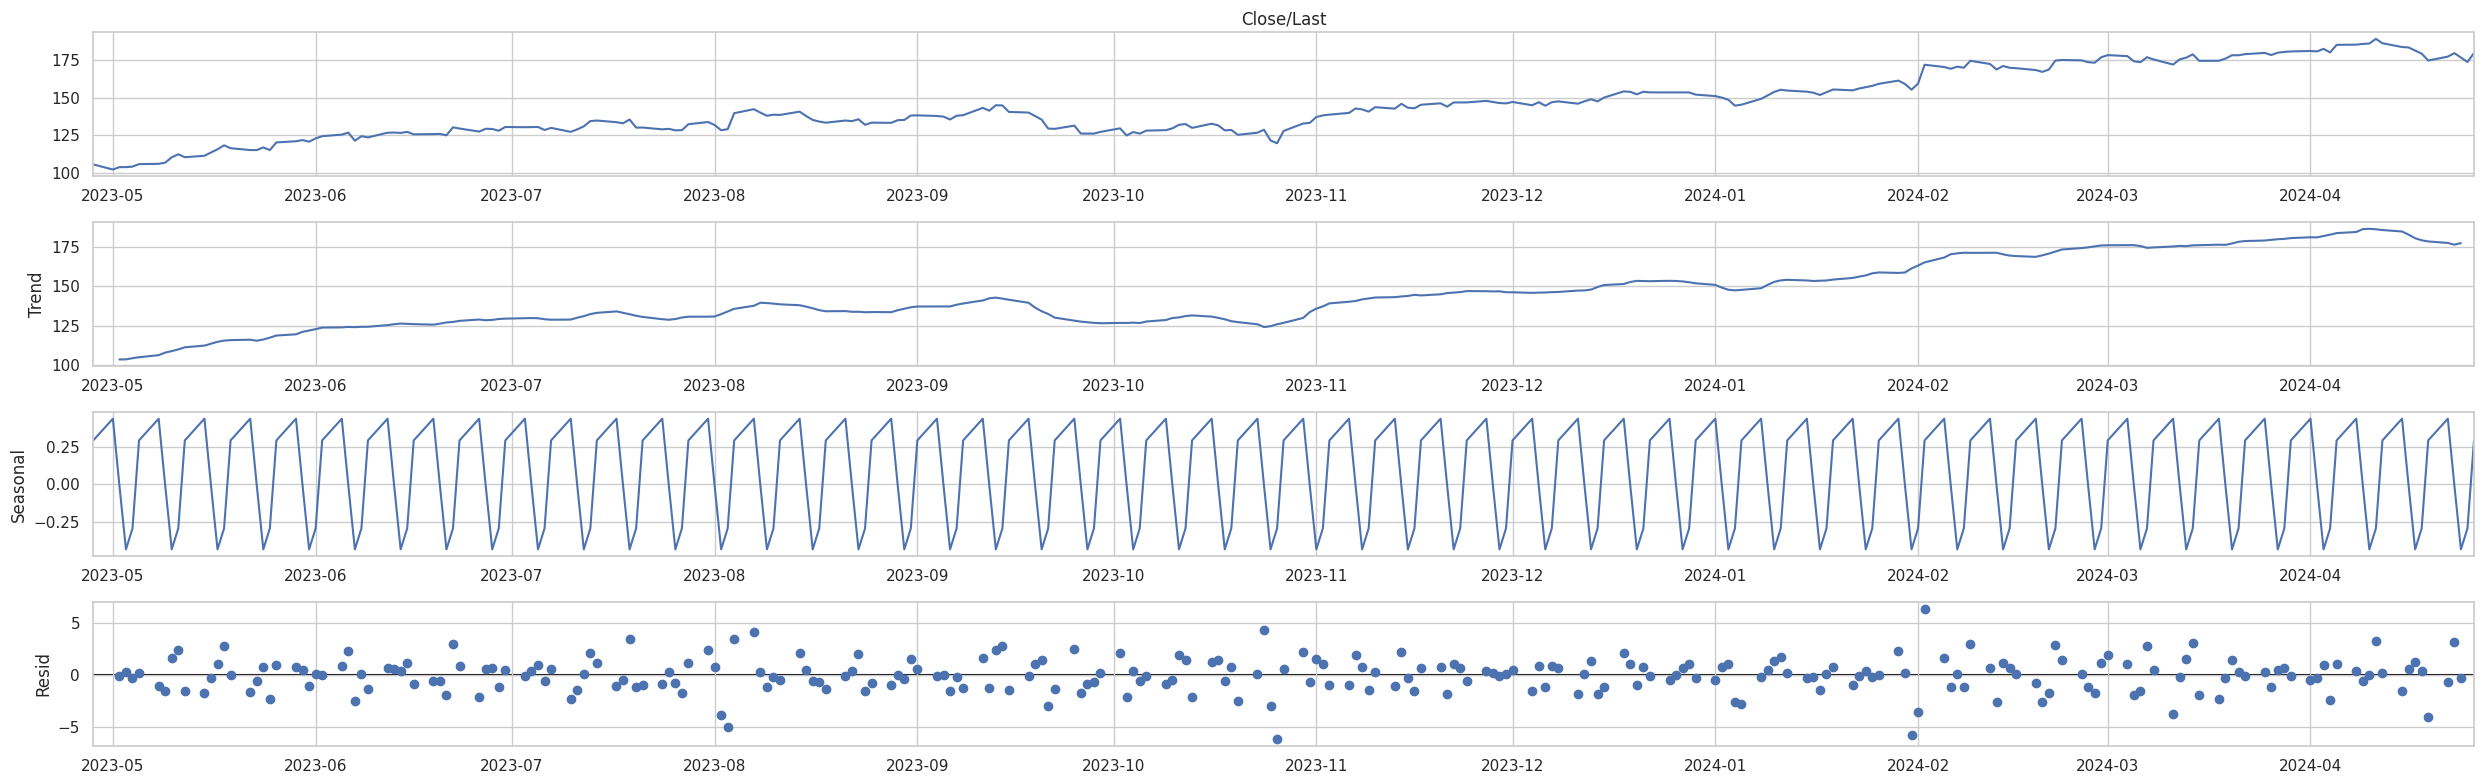

In [ ]:
res = sm.tsa.seasonal_decompose(df1)
plt.rc("figure", figsize=(25,8))
resplot = res.plot()

Исходя из данных, видно, что ряд не является стационарным и имеет тренд и сезонность. Конечно, можно использовать тест Дики-Фуллера на стационарность и привести временной ряд к данному виду. В таком случае значение ошибок будет гораздо меньше, чем в нестационарном, однако это делает ряд немного искусственным: приведение ряда к стационарному виду может привести к потере информации о трендах, циклах или других важных характеристиках данных. Это может существенно исказить представление о реальной природе временного ряда.

### Генерация и определение признаков для линейной регрессии

In [ ]:
data=df1.copy()

Напишем функцию, которая возвращает словарь, где ключами являются уникальные категории признака cat_feature, а значениями - средние по real_feature.

In [ ]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

В данной функции мы

1) Разбиваем данные на тренировочную и тестовую части

2) Генерируем лаговые признаки

3) Генерируем агрегированные признаки

In [ ]:
def preprocess_data(data, lag_start=5, lag_end=20, test_size=0.3):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['Close/Last'].shift(i)

    data["weekday"] = data.index.weekday
    data["month"] = data.index.month
    data["year"] = data.index.year

    # считаем средние только по тренировочной части, чтобы избежать лика (data leak)
    data["weekday_average"] = list(map(code_mean(data[:test_index], "weekday", "Close/Last").get, data.weekday))
    data["month_average"] = list(map(code_mean(data[:test_index], "month", "Close/Last").get, data.month))
    data["year_average"] = list(map(code_mean(data[:test_index], "year", "Close/Last").get, data.year))

    # выкидываем закодированные средними признаки
    data.drop(["weekday", 'month', 'year'], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Close/Last"], axis=1)
    y_train = data.loc[:test_index]["Close/Last"]
    X_test = data.loc[test_index:].drop(["Close/Last"], axis=1)
    y_test = data.loc[test_index:]["Close/Last"]

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(data)

X_train.shape, X_test.shape

((183, 18), (18, 18))

## Линейная регрессия (1 вариант использования признаков)

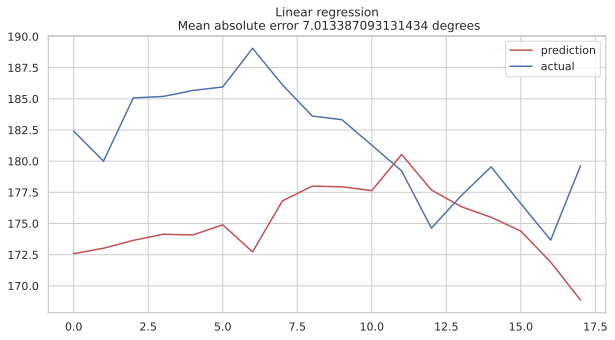

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)} degrees");

Средняя абсолютная ошибка составляет 7.013, что довольно немного при нестационарном ряде.















**Подробный анализ метрик будет представлен ниже**

Напишем функцию для расчета метрик. Все датафреймы, кроме датафрейма ETNA позволяют рассчитать такие метрики, как RAE, RSE, RMSLE. Последние метрики тоже рассчитаем, может в выводах пригодятся

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

def regression_quality_metrics_report(test, y_pred_1):

    rmse = np.sqrt( mean_squared_error(test, y_pred_1) )
    mae = mean_absolute_error(test, y_pred_1)
    rse = np.sqrt( ( (test - y_pred_1)**2 ).sum() / ( (test - test.mean())**2 ).sum() )
    rae = np.abs( test - y_pred_1 ).sum() / np.abs( test - test.mean() ).sum()
    mape = 100. / len(test) * np.abs( 1. - y_pred_1/test ).sum()
    rmsle = np.sqrt( mean_squared_log_error(test, y_pred_1) )

    return [rmse, mae, rse, rae, mape, rmsle]

In [ ]:
metrics_report = pd.DataFrame(columns=['RMSE', 'MAE', 'RSE', 'RAE', 'MAPE', 'RMSLE'])

metrics_report.loc['LinearRegression version1', :] = regression_quality_metrics_report(y_test, preds)

In [ ]:
metrics_report

,RMSE,MAE,RSE,RAE,MAPE,RMSLE
LinearRegression version1,8.278896,7.013387,1.975065,1.953287,3.818268,0.045949


Для второго варианта регрессии добавим новые признаки

In [ ]:
df1_copy1=pd.DataFrame(df1).copy()

In [ ]:
moving_avg_3 = df1_copy1.rolling(window=3).mean()['Close/Last'].shift(1) # обязательно делаем shift, чтобы не было утечки информации
moving_avg_5 = df1_copy1.rolling(window = 5).mean()['Close/Last'].shift(1)

df1_copy1['moving_avg_3'] = moving_avg_3
df1_copy1['moving_avg_5'] = moving_avg_5

In [ ]:
df1_copy1['trend'] = res.trend.shift(1)
df1_copy1['seasonality']=res.seasonal.shift(1)
df1_copy1.dropna(inplace = True)

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(df1_copy1, lag_start = 2, lag_end = 10)

## Линейная регрессия (2 вариант использования признаков)

0.8003057041951698


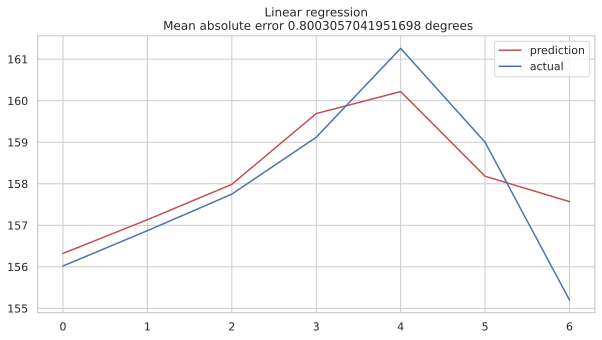

In [ ]:
lr = LinearRegression()

lr.fit(X_train, y_train)

preds_1 = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds_1, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds_1, y_test)} degrees");
print(mean_absolute_error(preds_1, y_test))

Средняя абсолютная ошибка существенно снизилась и составляет 0.8, что очень хорошо

In [ ]:
metrics_report1 = pd.DataFrame(columns=['RMSE', 'MAE', 'RSE', 'RAE', 'MAPE', 'RMSLE'])
metrics_report1.loc['LinearRegression version2', :] = regression_quality_metrics_report(y_test, preds_1)
metrics_report1

,RMSE,MAE,RSE,RAE,MAPE,RMSLE
LinearRegression version2,1.062968,0.800306,0.552665,0.490187,0.508209,0.006716


Поскольку в нашем датафрейме есть не только поле 'Close/Last', учтем колонки High, Low, Volume, Open как признаки

Для третьего варианта регрессии добавим новые признаки

In [ ]:
df1_copy2=df1_copy1.reset_index()

In [ ]:
#объединим датафреймы со вторым вариантом использования признаков(скользящие среднее, тренд и сезонность) с исходным датафреймом

In [ ]:
merged_df=df1_copy2.merge(f_data, on='Date', how='left')

In [ ]:
merged_df=merged_df.drop(['Close/Last_y'], axis=1)

In [ ]:
train_data = merged_df[merged_df['Date'] < '2023-12-29']
test_data = merged_df[merged_df['Date'] >= '2023-12-29']

# Выбираем признаки для обучения модели
X_train = train_data[['Volume', 'Open', 'High']]
X_test = test_data[['Volume', 'Open', 'High']]

# Выбираем целевую переменную (то, что мы хотим предсказать)
y_train = train_data['Close/Last_x']
y_test = test_data['Close/Last_x']

0.8605187430472453


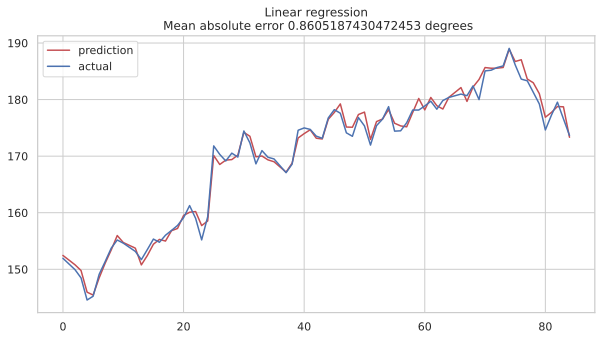

In [ ]:
lr = LinearRegression()

lr.fit(X_train, y_train)

preds_2 = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds_2, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds_2, y_test)} degrees");
print(mean_absolute_error(preds_2, y_test))

In [ ]:
metrics_report2 = pd.DataFrame(columns=['RMSE', 'MAE', 'RSE', 'RAE', 'MAPE', 'RMSLE'])
metrics_report2.loc['LinearRegression version3', :] = regression_quality_metrics_report(y_test, preds_2)
metrics_report2

,RMSE,MAE,RSE,RAE,MAPE,RMSLE
LinearRegression version3,1.120446,0.860519,0.097257,0.088632,0.506193,0.00646


MAE увеличилась с 0.8 до 0.86 относительно предыдущего набора признаков, однако все равно ошибка меньше, чем в первом наборе признаков. Для дальнейшего анализа будут использоваться только модели, учитывающие тренд и сезонность, а также простые модели, поскольку влияние таких признаков, как количество проданных акций(Volume) и др. ухудшает точность предсказания модели

## DecisionTree

Дерево решений — алгоритм машинного обучения(регрессии в нашем случае), основанный на бинарном дереве и являющийся фундаментальным компонентом случайного леса и бустингов, которые входят в число самых мощных алгоритмов машинного обучения на сегодняшний день.
Главным плюсом данного метода является гибкость в обработке сложных зависимостей, т.к. решающие деревья способны моделировать сложные нелинейные зависимости в данных, что позволяет им хорошо справляться с прогнозированием временных рядов, где могут быть различные тренды и сезонные колебания.
Главной недостаток деревьев-склонность к переобучению.

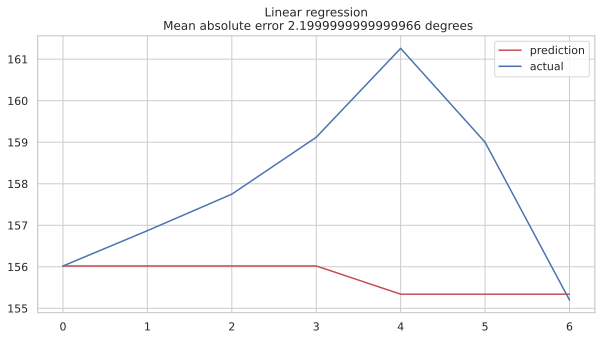

In [ ]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
preds_22 = dt.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds_22, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds_22, y_test)} degrees");

In [ ]:
metrics_report3 = pd.DataFrame(columns=['RMSE', 'MAE', 'RSE', 'RAE', 'MAPE', 'RMSLE'])
metrics_report3.loc['DecisionTree', :] = regression_quality_metrics_report(y_test, preds_22)
metrics_report3

,RMSE,MAE,RSE,RAE,MAPE,RMSLE
DecisionTree,2.970979,2.2,1.544691,1.3475,1.37856,0.018705


Таким образом, дерево решений показывает небольшую абсолютною ошибку, однако она выше относительно простой линейной регрессии с набором признаков(2 вариант)

## RandomForest

Случайный лес представляет собой пример ансамблевого алгоритма и основан на предсказаниях решающих деревьев. Идея ансамблевых моделей заключается в построенни большого количества простых моделей, результаты которого затем агрегируются.
Также ключевым преимуществом Random Forest является бóльшая устойчивость к переобучению, нежели у простого дерева решений. Это достигается за счет комбинирования прогнозов нескольких деревьев, что обычно приводит к более устойчивым и точным результатам.

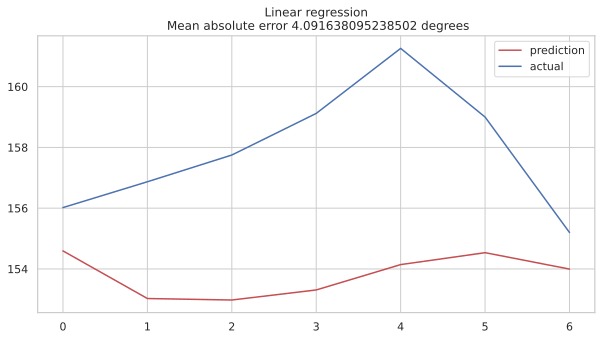

In [ ]:
rf = RandomForestRegressor(n_estimators=300)
rf.fit(X_train, y_train)
preds_3 = rf.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds_3, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds_3, y_test)} degrees");

In [ ]:
metrics_report4 = pd.DataFrame(columns=['RMSE', 'MAE', 'RSE', 'RAE', 'MAPE', 'RMSLE'])
metrics_report4.loc['RandomForest', :] = regression_quality_metrics_report(y_test, preds_3)
metrics_report4

,RMSE,MAE,RSE,RAE,MAPE,RMSLE
RandomForest,4.557618,4.091638,2.369627,2.506128,2.577188,0.028939


При количестве деревьев в 300 шт. MAE увеличилась в 2 раза относительно простого дерева решений

## Catboost

Catboost Regressor представляет собой модель градиентного бустинга, ключевые преимущества которого следующие
1.   Включает в себя механизмы регуляризации, что помогает предотвратить переобучение модели даже на больших объемах данных.
2.   Хорошо оптимизирован для эффективной работы с большими объемами данных, что позволяет быстро обучать модель и делать прогнозы.
3.   Прост в использовании и довольно точен.

In [ ]:
from catboost import CatBoostRegressor
%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 7, 5

In [ ]:
cb = CatBoostRegressor(n_estimators=300)
cb.fit(X_train, y_train)
preds_4 = cb.predict(X_test)

Learning rate set to 0.083029
0:	learn: 9.7357602	total: 2.3ms	remaining: 689ms
1:	learn: 9.1773121	total: 4.64ms	remaining: 691ms
2:	learn: 8.5999408	total: 6.92ms	remaining: 685ms
3:	learn: 8.0782683	total: 9.27ms	remaining: 686ms
4:	learn: 7.6285234	total: 11.8ms	remaining: 697ms
5:	learn: 7.1550079	total: 13.8ms	remaining: 676ms
6:	learn: 6.7405866	total: 16ms	remaining: 669ms
7:	learn: 6.3492447	total: 18.1ms	remaining: 662ms
8:	learn: 6.0022481	total: 20.3ms	remaining: 655ms
9:	learn: 5.6734872	total: 22.4ms	remaining: 650ms
10:	learn: 5.3931162	total: 24.6ms	remaining: 646ms
11:	learn: 5.1520232	total: 26.7ms	remaining: 641ms
12:	learn: 4.9243234	total: 29.2ms	remaining: 644ms
13:	learn: 4.6774573	total: 31.5ms	remaining: 643ms
14:	learn: 4.4742235	total: 33.7ms	remaining: 640ms
15:	learn: 4.2787008	total: 35.8ms	remaining: 636ms
16:	learn: 4.0938562	total: 38ms	remaining: 632ms
17:	learn: 3.9534386	total: 40ms	remaining: 627ms
18:	learn: 3.8004510	total: 42.1ms	remaining: 623ms

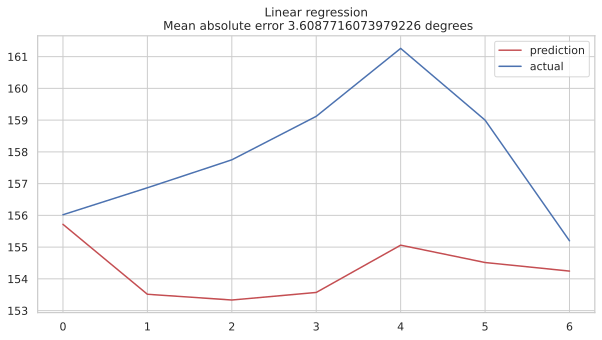

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(preds_4, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds_4, y_test)} degrees");
plt.show()

In [ ]:
metrics_report5 = pd.DataFrame(columns=['RMSE', 'MAE', 'RSE', 'RAE', 'MAPE', 'RMSLE'])
metrics_report5.loc['Catboost', :] = regression_quality_metrics_report(y_test, preds_4)
metrics_report5

,RMSE,MAE,RSE,RAE,MAPE,RMSLE
Catboost,4.159114,3.608772,2.162434,2.210373,2.271345,0.026371


MAE довольно небольшая, что говорит о точности модели, однако относительно линейной регрессии (2 и 3 вариант признаков) Catboost показывает меньшую точность прогноза.

Соберем получившиеся MAE и добавим другие метрики качества прогноза в одном датафрейме

In [ ]:
metric_report_part_1=pd.concat([metrics_report,metrics_report1,metrics_report2,metrics_report3,metrics_report4,metrics_report5])
metric_report_part_1

,RMSE,MAE,RSE,RAE,MAPE,RMSLE
LinearRegression version1,8.278896,7.013387,1.975065,1.953287,3.818268,0.045949
LinearRegression version2,1.062968,0.800306,0.552665,0.490187,0.508209,0.006716
LinearRegression version3,1.120446,0.860519,0.097257,0.088632,0.506193,0.00646
DecisionTree,2.970979,2.2,1.544691,1.3475,1.37856,0.018705
RandomForest,4.557618,4.091638,2.369627,2.506128,2.577188,0.028939
Catboost,4.159114,3.608772,2.162434,2.210373,2.271345,0.026371


Таким образом, среди выше перечисленных моделей наименьшие размеры ошибки имеет линейная регрессия с признаками в виде скользящего среднего с окном в 3 и 5, а также учет тренда и сезонности. Также довольно низкий показатель у третьего варианта использования признаков(признаки второго варианта+включение в признаки значения колонок Low, High, Open, Volume, хотя они(последние признаки) уменьшают точность модели. Самое высокое значение у первой линейной регресии.

## Экспоненциальное сглаживание

Разные виды экспоненциального сглаживания представлют собой адаптивные модели, которые часто не являются довольно точными. Однако стоит их рассмотреть, поскольку являются частным случаем модели ARIMA. Также одними из главных преимуществ данных моделей является учет последних наблюдейний с разной весовой значимостью и быстрая реакция на изменения во временном ряде, что делает такие модели подходящими для краткосрочного прогнозирования

In [ ]:
data2=df1.copy()

In [ ]:
date_cut = pd.to_datetime("2023-12-29", format='%Y-%m-%d')
test = data2.loc[date_cut:]
train = data2.loc[:date_cut]

## Линейный тренд Хольта и экспоненциальный тренд

**Линейный тренд Хольта** представляет собой модификацию метода экспоненциального сглаживания, включающую в себя компонент тренда.Этот метод учитывает как уровень (level) временного ряда, так и его тренд, предполагая, что тренд изменяется линейно со временем.Также данный метод подходит для данных с постепенно меняющимся трендом, что актуально для нашего временного ряда

**Экспоненциальный тренд** также учитывает изменения в тренде временного ряда, но предполагает экспоненциальное изменение тренда со временем.Этот метод основан на модели экспоненциального роста или убывания и может быть более гибким в адаптации к нелинейным изменениям тренда.

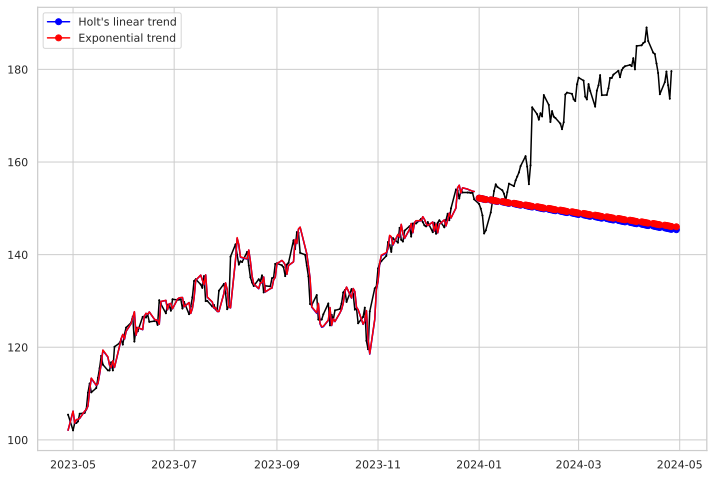

In [ ]:
fit1 = Holt(train, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast1 = fit1.forecast(86).rename("Holt's linear trend")
fit2 = Holt(train, exponential=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast2 = fit2.forecast(86).rename("Exponential trend")

plt.figure(figsize=(12, 8))
plt.plot(data2, marker="o", color="black", markersize=1)
plt.plot(fit1.fittedvalues, color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.legend([line1, line2], [fcast1.name, fcast2.name])

Даже без метрик видно, что прогноз довольно неточный, однако попробуем методы Хольта-Винтерса, которые учитывают тренд, сезонность и уровень временного ряда.

Существуют два основных варианта использования метода Хольта-Винтерса. Будем использовать их:

1. Holt-Winters (additive-additive-seasonal):
   - В этом методе используются аддитивные компоненты для тренда, сезонности и уровня временного ряда.
   - Тренд и сезонные колебания добавляются к уровню временного ряда, что позволяет учесть как линейные изменения, так и постоянные амплитуды сезонности.

2. Holt-Winters (additive-multiplicative-seasonal):
   - В этом варианте используются аддитивные компоненты для тренда и мультипликативные компоненты для сезонности.
   - Такой подход учитывает изменения сезонности в зависимости от уровня временного ряда, что может быть особенно полезно при сезонных колебаниях, которые меняются пропорционально уровню.

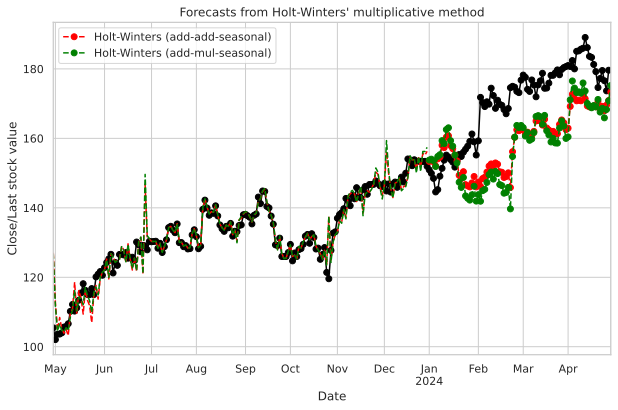

In [ ]:
fit3 = ExponentialSmoothing(train,seasonal_periods=86,trend="add",seasonal="add",
                            use_boxcox=True,initialization_method="estimated",
                            ).fit()
fit4 = ExponentialSmoothing(train,seasonal_periods=86,trend="add",seasonal="mul",
                            use_boxcox=True,initialization_method="estimated",
                            ).fit()

ax = data.plot(figsize=(10, 6),marker="o",color="black",
    title="Forecasts from Holt-Winters' multiplicative method",)
ax.set_ylabel("Close/Last stock value")
ax.set_xlabel("Year")
fit3.fittedvalues.plot(ax=ax, style="--", color="red")
fit4.fittedvalues.plot(ax=ax, style="--", color="green")

fit3.forecast(86).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)
fit4.forecast(86).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)

plt.show()

In [ ]:
y_holt_pred=fit1.forecast(86)
y_pred_=y_holt_pred.to_frame(name='Close/Last').reset_index()
y_exp_trend=fit2.forecast(86)
y_pred_0=y_exp_trend.to_frame(name='Close/Last').reset_index()

In [ ]:
y_add_pred=fit3.forecast(86)
y_pred_1=y_add_pred.to_frame(name='Close/Last').reset_index()
test_df=test.to_frame(name='Close/Last').reset_index()
y_add_mul_pred=fit4.forecast(86)
y_pred_2=y_add_mul_pred.to_frame(name='Close/Last').reset_index()

Соберем отчет по метрикам для экспоненциального сглаживания

In [ ]:
metrics_report6 = pd.DataFrame(columns=['RMSE', 'MAE', 'RSE', 'RAE', 'MAPE', 'RMSLE'])

metrics_report6.loc['Holt"s linear_trend', :] = regression_quality_metrics_report(test_df['Close/Last'].values, y_pred_['Close/Last'].values)
metrics_report6.loc['Exponential trend', :] = regression_quality_metrics_report(test_df['Close/Last'].values, y_pred_0['Close/Last'].values)
metrics_report6.loc['Holt-Winters (add-add-seasonal)', :] = regression_quality_metrics_report(test_df['Close/Last'].values, y_pred_1['Close/Last'].values)
metrics_report6.loc['Holt-Winters (add-mul-seasonal)', :] = regression_quality_metrics_report(test_df['Close/Last'].values, y_pred_2['Close/Last'].values)
metrics_report6

,RMSE,MAE,RSE,RAE,MAPE,RMSLE
"Holt""s linear_trend",25.036583,21.741325,2.176918,2.245302,12.34596,0.153265
Exponential trend,24.693543,21.447047,2.147091,2.214911,12.179205,0.150953
Holt-Winters (add-add-seasonal),13.407032,12.227685,1.165734,1.262795,7.102167,0.080695
Holt-Winters (add-mul-seasonal),14.805117,13.28396,1.287297,1.371881,7.757109,0.090608


Таким образом, моделью, имеющая наименьшую разницу между значениями, спрогнозированными моделью и фактическими значениями, и имеющая наименьюшую среднюю ошибку(как в процентном выражении, так и в абсолютном) является вариант использования модели Хольта-Винтерса, а именно аддитивно-аддитивно-сезонная модель.

## Использование библиотеки ETNA для прогнозирования временных рядов

Использование данной библиотеки имеет ряд преимуществ:
1.   Все модели в ETNA имеют единый интерфейс, поэтому, независимо от предыдущих шагов, можно использовать любую из представленных моделей.
2.   Много моделей представлено в библиотеке(от Prophet до нейронных сетей)

Также есть недостатки в виде ограниченности метрик(например, нет RAE, RMSLE) и некая локальность( я имею ввиду узкий набор примеров использования методов в открытых источниках)

In [ ]:
#импортируем необходимые модули

In [ ]:
from etna.datasets.tsdataset import TSDataset
from etna.models import NaiveModel,ProphetModel, LinearPerSegmentModel
from etna.analysis import plot_forecast
from etna.analysis import plot_backtest
from etna.pipeline import Pipeline
from etna.metrics import MAE, RMSE, MAPE
from etna.transforms import STLTransform, LagTransform, MeanSegmentEncoderTransform

In [ ]:
data_close=f_data[['Date','Close/Last']].sort_values(by='Date', ascending=True)
data_close.head(3)

,Date,Close/Last
0,2023-04-28,105.45
1,2023-05-01,102.05
2,2023-05-02,103.63


Приведем данные к формату, с которым работает ETNA:

* колонка `timestamp` - время в формате datetime
* колонка `target` - целевая переменная (прогнозируемый ряд)
* колонка `segment` - `main` в случае, если целевая переменная - это один ряд

In [ ]:
data_close["target"] = data_close["Close/Last"]
data_close["timestamp"]=data_close["Date"]
data_close.drop(columns=["Date", "Close/Last"], inplace=True)
data_close["segment"] = "main"
data_close.head()

,target,timestamp,segment
0,105.45,2023-04-28,main
1,102.05,2023-05-01,main
2,103.63,2023-05-02,main
3,103.65,2023-05-03,main
4,104.00,2023-05-04,main


В ETNA есть специальный класс для работы с временными рядами - TSDataset, приведем наши данные к этому формату.

In [ ]:
data = TSDataset.to_dataset(data_close)
data.head()

segment,main
feature,target
timestamp,
2023-04-28,105.45
2023-05-01,102.05
2023-05-02,103.63
2023-05-03,103.65
2023-05-04,104.00


Укажем временной шаг (будние дни)

In [ ]:
ts = TSDataset(data,freq="B")
ts.head()

segment,main
feature,target
timestamp,
2023-04-28,105.45
2023-05-01,102.05
2023-05-02,103.63
2023-05-03,103.65
2023-05-04,104.00


In [ ]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: B
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2023-04-28    2024-04-26     261            0


In [ ]:
#данные начала и окончания временного ряда совпадают, пропущенных значений нет

In [ ]:
#разобъем данные на тестовую и тренировочную части

In [ ]:
train_ts, test_ts = ts.train_test_split(
    train_start="2023-04-28",
    train_end="2023-12-28",
    test_start="2023-12-29",
    test_end="2024-04-26",
)

## Наивная модель

Предполагает, что последний период прогнозируемого временного ряда лучше всего описывает будущее этого ряда. Простейшая модель y(t+1)=x(t), где x(t) – последнее наблюдаемое значение, y(t+1) –прогноз.

In [ ]:
HORIZON = 86 # горизонт прогнозирования
# Fit the model
model1 = NaiveModel(lag=5)
model1.fit(train_ts)
# Make the forecast
future_ts = train_ts.make_future(future_steps=HORIZON, tail_steps=model1.context_size)

forecast_ts = model1.forecast(future_ts, prediction_size=HORIZON)

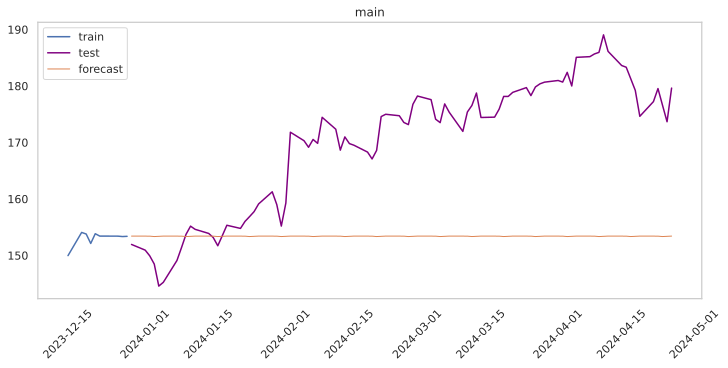

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

In [ ]:
#посчитаем наши метрик

In [ ]:
mape = MAPE()
naive_mape=mape(y_true=test_ts, y_pred=forecast_ts)

In [ ]:
rmse=RMSE()
naive_rsme=rmse(y_true=test_ts, y_pred=forecast_ts)

In [ ]:
mae=MAE()
naive_mae=mae(y_true=test_ts, y_pred=forecast_ts)

In [ ]:
#cоберем все в датафрейм

In [ ]:
naive=[{'MAE':naive_mae['main'],'RSME':naive_rsme['main'],'MAPE':naive_mape['main']}]

In [ ]:
naive_df=pd.DataFrame(naive)

In [ ]:
naive_df['model']='Naive model'

In [ ]:
naive_df

,MAE,RSME,MAPE,model
0,17.45657,20.181268,9.913516,Naive model


## Prophet

Библиотека Prophet использует аддитивную модель для прогнозирования временных рядов. Аддитивная модель предполагает, что значение временного ряда можно разложить на несколько компонент, таких как тренд, сезонность, праздничные эффекты и остатки.
Тренд моделируется с использованием гибкой линейной модели, которая может аппроксимировать нелинейные изменения во временном ряду. Сезонность моделируется с помощью фурье-рядов, позволяющих учесть сезонные колебания с различными периодами. Праздничные эффекты моделируются путем добавления индикаторов праздников в модель.
Prophet также автоматически настраивает гиперпараметры модели, такие как гибкость тренда и сезонности, а также влияние праздников. Он также предоставляет возможность пользователю настраивать некоторые параметры, такие как сезонность, шум и другие.

In [ ]:
model2 = ProphetModel()

model2.fit(train_ts)

# Make the forecast
future_ts = train_ts.make_future(HORIZON)
forecast_ts = model2.forecast(future_ts)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8guxje_2/bqopr51w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8guxje_2/2mb0yd0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50605', 'data', 'file=/tmp/tmp8guxje_2/bqopr51w.json', 'init=/tmp/tmp8guxje_2/2mb0yd0m.json', 'output', 'file=/tmp/tmp8guxje_2/prophet_model1r_92izf/prophet_model-20240611010857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:08:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:08:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
mape = MAPE()
prophet_mape=mape(y_true=test_ts, y_pred=forecast_ts)

In [ ]:
rmse=RMSE()
prophet_rsme=rmse(y_true=test_ts, y_pred=forecast_ts)

In [ ]:
mae=MAE()
prophet_mae=mae(y_true=test_ts, y_pred=forecast_ts)

In [ ]:
#соберем все в датафрейм

In [ ]:
prophet=[{'MAE':prophet_mae['main'],'RSME':prophet_rsme['main'],'MAPE':prophet_mape['main']}]

In [ ]:
prophet_df=pd.DataFrame(prophet)

In [ ]:
prophet_df['model']='Prophet'

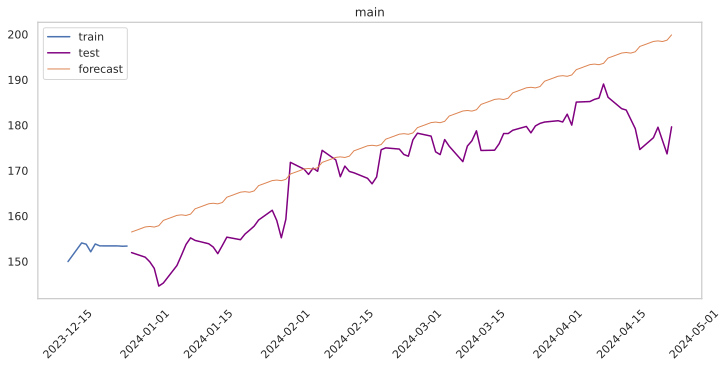

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

Несмотря на описание модели и формулу расчета, "пророчество" на уровне наивной модели, т.е. является довольно неточным

## Модель ARIMA c использованием сущности Pipeline

Ключевым преимуществом использования данной линейной модели является учет тренда для прогнозирования временного ряда, поскольку при использовании второго варианта линейной регрессии ошибка была довольно низкой относительно других, но в данном случае разобъем на 5 фолдов и добавим сезонность в 7 дней(последняя определяется по графику сезонной декомпозиции (в данном ноутбуке обозначается как res)

Для обучения и валидации модели будем использовать сущность `Pipeline`. В целом, использование `Pipeline` позволит ускорить и упростить обучение и тестирование модели. Например, разбиение на тренировочные и тестовые выборки при запуске кросс валидации в таком случае будет производиться автоматически.

`Pipeline` имеет несколько параметров:

* `model` - модель, которая будет обучаться и тестироваться;
* `horizon` - горизонт прогнозирования;
* `transforms` - список преобразований, которые нужно применить к данным.

In [ ]:
from etna.pipeline import Pipeline
from etna.metrics import MAE, SMAPE
from etna.transforms import STLTransform, LagTransform, MeanSegmentEncoderTransform

pipe = Pipeline(
    transforms=[
        STLTransform(in_column="target", period=7, model="arima"),
        LagTransform(in_column="target", lags=list(range(3, 10, 1))),
    ],
    model=LinearPerSegmentModel(),
    horizon=3
)

In [ ]:
ts.info()

<class 'etna.datasets.TSDataset'>
num_segments: 1
num_exogs: 0
num_regressors: 0
num_known_future: 0
freq: B
         start_timestamp end_timestamp  length  num_missing
segments                                                   
main          2023-04-28    2024-04-26     261            0


In [ ]:
metrics, forecast, _ = pipe.backtest(
    ts=ts, metrics=[MAE(), MAPE(),RMSE()], n_folds=2)

metrics

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s


,segment,MAE,MAPE,RMSE,fold_number
0,main,5.454556,3.090877,5.725467,0
0,main,2.433853,1.392458,3.304932,1


In [ ]:
#посчитаем метрики

In [ ]:
mae_value = metrics.mean().to_dict()["MAE"]
mae_value

3.9442044639867744

In [ ]:
mape_value = metrics.mean().to_dict()["MAPE"]
mape_value

2.2416674801988843

In [ ]:
rmse_value = metrics.mean().to_dict()["RMSE"]
rmse_value

4.515199599698362

In [ ]:
arima=[{'MAE':mae_value,'RSME':rmse_value,'MAPE':mape_value}]

In [ ]:
arima_df=pd.DataFrame(arima)

In [ ]:
arima_df['model']='ARIMA'

## Подведение итогов

Выведем все наши данные метрик качества прогноза на разных методах прогнозирования

In [ ]:
with_etna_1=pd.concat([naive_df, prophet_df], axis=0)

In [ ]:
etna_report=pd.concat([with_etna_1,arima_df], axis=0)
etna_report

,MAE,RSME,MAPE,model
0,17.456570,20.181268,9.913516,Naive model
0,8.262146,8.262146,4.885214,Prophet
0,3.944204,4.515200,2.241667,ARIMA


Таким образом, среди методов,имеющих наименьшие показатели ошибок прогноза, самые лучшие показатели у модели ARIMA, что не удивительно, поскольку данная модель учитывает тренд, который ярко выражен на графике декомпозиции временного ряда, также при учете тренда в качестве признака в простой линейной регрессии тоже ошибка уменьшилась. Наименее точная модель для составления прогноза оказалась Наивная модель и Prophet.

In [ ]:
results_without_etna=pd.concat([metric_report_part_1, metrics_report6])
results_without_etna

,RMSE,MAE,RSE,RAE,MAPE,RMSLE
LinearRegression version1,8.278896,7.013387,1.975065,1.953287,3.818268,0.045949
LinearRegression version2,1.062968,0.800306,0.552665,0.490187,0.508209,0.006716
LinearRegression version3,1.120446,0.860519,0.097257,0.088632,0.506193,0.00646
DecisionTree,2.970979,2.2,1.544691,1.3475,1.37856,0.018705
RandomForest,4.557618,4.091638,2.369627,2.506128,2.577188,0.028939
Catboost,4.159114,3.608772,2.162434,2.210373,2.271345,0.026371
"Holt""s linear_trend",25.036583,21.741325,2.176918,2.245302,12.34596,0.153265
Exponential trend,24.693543,21.447047,2.147091,2.214911,12.179205,0.150953
Holt-Winters (add-add-seasonal),13.407032,12.227685,1.165734,1.262795,7.102167,0.080695
Holt-Winters (add-mul-seasonal),14.805117,13.28396,1.287297,1.371881,7.757109,0.090608


Среди вышеперечисленных методов и библиотек наиболее точными с точки зрения абсолютных и относительных ошибок прогноза является линейная регрессия с такими признаками, как скользящее среднее с окном в 3 и 5, а также учет тренда и сезонности.На втором месте по точности прогноза оказался 3 вариант использования линейной регрессии, включающий в себя другие поля изначального датафрейма такие, как количество проданных акций, самая высокая цена, самая низкая цена, цена открытия за период. Но я бы не стала их использовать в дальнейшем, поскольку эти признаки уменьшили точность модели.Также довольно низкая MAE у дерева решений и составляет 2.2. Также довольно хорошо себя показал градиентный бустнинг(CatBoost в нашем случае), который справился лучше, случайный лес( среднеквадратичная ошибка Catboost примерно равна 4.2).

Варианты экспоненциального сглаживания (хотя их довольно просто интерпретировать) имеют слишком большую величину ошибков(MAPE от 7.1 до 12.3 по различным вариантам), поэтому я бы их не рекоммендовала использовать практически для любого временного ряда, тренд которых не линейный и который (даже без расчета теста Дикки-Фуллера) понятно, что не стационарен. Как мы видим, наибольшие значение ошибок имеет метод Хольта, который должен учитывать тренд(но не делает этого в полной мере), поскольку на нескольких других моделях уже было определено влияние тренда.

Таким образом, при прогнозировании временного ряда цены закрытия акций Амазона лучше всего показала себя простая линейная регрессия с добавлением признаков тренда, сезонности и скользящего среднего. Также хорошо себя показала модель ARIMA,которая тоже учитывает тренд. Также при дальнейшем прогнозировании стоимости акций данной компании можно использовать градиентный бустинг и дерево решений.
По метрикам я бы оставила MAE, MAPE(если необходимо было бы отправить анализ сотруднику, который уже знаком с этим временным рядом), а также относительные ошибки RMSE и прологарифмированный ее вариант(для более продвинутых юзеров).

Подводя итог, в данном проекте я применила основные методы прогнозирования временных рядов, используемых на финансовом рынке, определелила наиболее подходящие методы прогноза с учетом метрик его качества, а также построили свечной график и выделили основные свечные паттерны за начало 2024 года.